In [1]:
import qubic.toolchain as tc
import qubic.rpc_client as rc
import qubitconfig.qchip as qc
from distproc.hwconfig import FPGAConfig, load_channel_configs
import numpy as np

## Load Configs and Define Circuit

define FPGA config; this has timing information for the scheduler. For now it is fine to use the default config

In [2]:
fpga_config = FPGAConfig()

load channel configs (firmware channel mapping + configuration, see [Understanding Channel Configuration](https://gitlab.com/LBL-QubiC/software/-/wikis/Understanding-Channel-Configuration) for details), and QChip object, which contains calibrated gates + readout.


In [3]:
channel_configs = load_channel_configs('channel_config.json')
qchip = qc.QChip('qubitcfg.json')

As an alternative to the above, if you're using the chipcalibration repository, you can load all three configs like this:

In [5]:
import chipcalibration.config as cfg
chipname = 'X4Y2/sian' #this is a folder in the 'qchip' submodule of chipcalibration, containing the name of your chip
fpga_config, qchip, channel_config = cfg.load_configs(chipname)

Define the quantum circuit. For details on the QubiC circuit format and supported operations, see [compiler.py](https://gitlab.com/LBL-QubiC/distributed_processor/-/blob/master/python/distproc/compiler.py)

In [6]:
circuit = [
    #Allow qubit to decay to 0 state between shots
    {'name': 'delay', 't': 500.e-6}, 
    
    #play a pi/2 pulse on Q1
    {'name': 'pulse', 'phase': 0, 'freq': 4675138775, 'amp': 0.48150320341813146, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q1.qdrv'}, 
    
    #play two more pi/2 pulses on Q1, this time using calibrated gates
    {'name': 'X90', 'qubit': 'Q1'},
    {'name': 'X90', 'qubit': 'Q1'},
    
    #play a pi/2 pulse on Q2
    {'name': 'pulse', 'phase': 0, 'freq': 4944383311, 'amp': 0.334704954261188, 'twidth': 2.4e-08,
     'env': {'env_func': 'cos_edge_square', 'paradict': {'ramp_fraction': 0.25}},
     'dest': 'Q2.qdrv'}, 
    
    #scheduling barrier ensures that both readouts start after the pulses
    {'name': 'barrier', 'qubit': ['Q1', 'Q2']},
    
    #This time, use calibrated gates for measurement
    {'name': 'read', 'qubit': 'Q1'},
    {'name': 'read', 'qubit': 'Q2'}
]

## Compile and Assemble

Compile the program. The output of the compile stage is a distributed processor assembly program, which consists of initialization/termination statements, as well as a list of scheduled pulses for each core. Notice that the calibrated X90 gates resolve to the same pulse as the manually specified pi/2 pulses. This time, our program uses two cores, one scoped to `('Q1.qdrv', 'Q1.rdrv', 'Q1.rdlo')`, and another to `('Q2.qdrv', 'Q2.rdrv', 'Q2.rdlo')`.

In [7]:
compiled_prog = tc.run_compile_stage(circuit, fpga_config, qchip)
compiled_prog.program

{('Q1.qdrv', 'Q1.rdrv', 'Q1.rdlo'): [{'op': 'phase_reset'},
  {'op': 'pulse',
   'freq': 4675138775,
   'phase': 0,
   'amp': 0.48150320341813146,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_fraction': 0.25, 'twidth': 2.4e-08}},
   'start_time': 250005,
   'dest': 'Q1.qdrv'},
  {'op': 'pulse',
   'freq': 4670352789.5315,
   'phase': 0.067896,
   'amp': 0.50095,
   'env': {'env_func': 'DRAG',
    'paradict': {'alpha': 0,
     'sigmas': 3,
     'delta': -260157670.03385544,
     'twidth': 3e-08}},
   'start_time': 250017,
   'dest': 'Q1.qdrv'},
  {'op': 'pulse',
   'freq': 4670352789.5315,
   'phase': 0.20368799999999998,
   'amp': 0.50095,
   'env': {'env_func': 'DRAG',
    'paradict': {'alpha': 0,
     'sigmas': 3,
     'delta': -260157670.03385544,
     'twidth': 3e-08}},
   'start_time': 250032,
   'dest': 'Q1.qdrv'},
  {'op': 'pulse',
   'freq': 6557848275.86207,
   'phase': 0.0,
   'amp': 0.041,
   'env': {'env_func': 'cos_edge_square',
    'paradict': {'ramp_f

Run the assembler to convert the above program into machine code that we can load onto the FPGA:

In [8]:
raw_asm = tc.run_assemble_stage(compiled_prog, channel_configs)

## Connect to Server and Run Circuit

Now that we've defined our circuit and compiled it to machine code, we can submit it to the ZCU216 and run it.

Instantiate the runner client:

In [11]:
runner = rc.CircuitRunnerClient(ip='192.168.1.122', port=9095)

Submit the circuit to the server, and collect 5000 shots: 

In [12]:
s11 = runner.run_circuit_batch([raw_asm], 5000)

A list of dictionaries of downconverted + integrated complex (IQ) values is returned. The list has only one element since we only have one circuit. Here, we're using both Q1 and Q2, so we get back data for channel 'Q1.rdlo', and channel 'Q2.rdlo'

Text(0.5, 1.0, 'Q2')

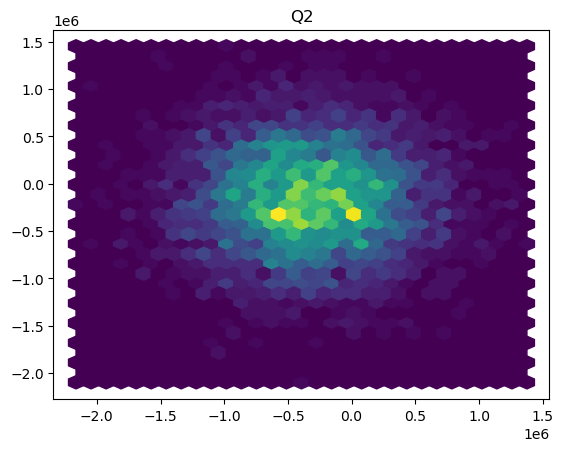

In [14]:
plt.hexbin(s11[0]['Q2.rdlo'].real, s11[0]['Q2.rdlo'].imag, gridsize=30)
plt.title('Q2')

Text(0.5, 1.0, 'Q1')

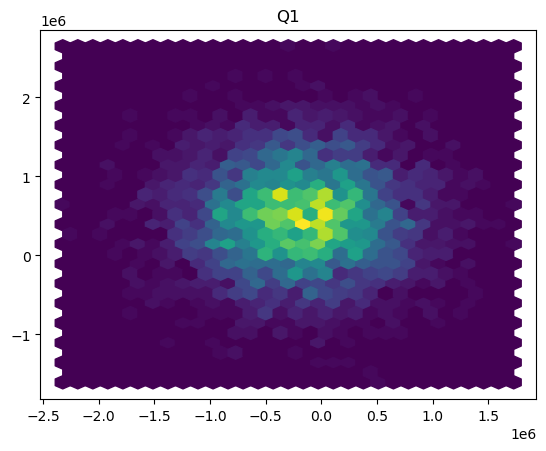

In [15]:
plt.hexbin(s11[0]['Q1.rdlo'].real, s11[0]['Q1.rdlo'].imag, gridsize=30)
plt.title('Q1')